In [1]:
import numpy as np
import tensorflow as tf
from image_utils import image_from_url
from lstm import MaxLikelihoodLSTM, PolicyGradientLSTM
from data import PGData, COCOData

In [2]:
def initialize_uninitialized(sess):
    ruv = set(sess.run(tf.report_uninitialized_variables()))
    uv = [v for v in tf.global_variables() if v.name.split(':')[0].encode('ascii') in ruv]
    tf.variables_initializer(uv).run()

In [3]:
mledata = COCOData()
pgdata = PGData()

In [4]:
lstm = MaxLikelihoodLSTM(tf.constant(mledata.word_embedding, dtype=tf.float32), learning_rate=5e-3, batch_size=100)
with tf.variable_scope("generator"):
    lstm.build_model()

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

lstm.train(sess, mledata, max_iterations=300)
lstm.save_model(sess, "mle300")

tf.reset_default_graph()
sess.close()

iter 0, cross-entropy: 110.69351196289062, accuracy: 0.0018018018454313278
iter 10, cross-entropy: 52.924198150634766, accuracy: 0.16621984541416168
iter 20, cross-entropy: 45.41652297973633, accuracy: 0.2798541486263275
iter 30, cross-entropy: 44.96426773071289, accuracy: 0.3088364005088806
iter 40, cross-entropy: 41.96060562133789, accuracy: 0.3268722593784332
iter 50, cross-entropy: 38.953208923339844, accuracy: 0.34454545378685
iter 60, cross-entropy: 37.91774368286133, accuracy: 0.3520362079143524
iter 70, cross-entropy: 38.18503952026367, accuracy: 0.3593466281890869
iter 80, cross-entropy: 37.46135711669922, accuracy: 0.35534319281578064
iter 90, cross-entropy: 37.22952651977539, accuracy: 0.341850221157074
iter 100, cross-entropy: 36.48466110229492, accuracy: 0.35231316089630127
iter 110, cross-entropy: 35.3934326171875, accuracy: 0.3633125424385071
iter 120, cross-entropy: 34.1655158996582, accuracy: 0.3739837408065796
iter 130, cross-entropy: 31.75765609741211, accuracy: 0.39

In [5]:
sess = tf.InteractiveSession()
lstm = PolicyGradientLSTM(tf.constant(pgdata.word_embedding, dtype=tf.float32), learning_rate=5e-4, batch_size=100)

lstm.load_model(sess, "models/mle30")
initialize_uninitialized(sess)

INFO:tensorflow:Restoring parameters from models/mle30


In [6]:
captions = []
probs = []
indexes = []
rewards = []

In [7]:
for i in range(1):
    caption, prob, index, reward = lstm.train(sess, pgdata)
    pgdata.shuffle()
    print(np.mean(reward))
    print("------------")
    captions.extend(caption)
    probs.extend(prob)
    indexes.extend(index)
    rewards.extend(reward)

0.879594180168
------------


In [7]:
tf.reset_default_graph()
sess.close()

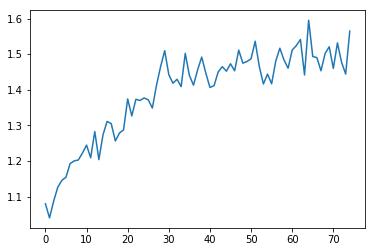

In [18]:
import matplotlib.pyplot as plt

rewards_arr = np.array(rewards)
plt.plot(np.mean(np.reshape(rewards_arr[:, -1], (75, 100)), axis=1))
# plt.plot(rewards_arr[:, -1])
plt.show()

In [21]:
from pyciderevalcap.eval import CIDErEvalCap as ciderEval
cand_list, ref = [], {}
for i in range(1000, 2000):
    idx = str(i)
    ref[idx]  = pgdata.data['train_image_idx_to_captions'][idx][0:-1]
    cand_list.append({'image_id': idx, 'caption': pgdata.data['train_image_idx_to_captions'][idx][-1]['caption']})

scorer = ciderEval(ref, cand_list, "coco-val-df")
scores = scorer.evaluate()

In [22]:
np.mean(scores)

1.7911916746177574